In [1]:
import pandas as pd

## Convert Exel table to DataFrame

In [2]:
data_df = pd.read_excel('TiO2-ions.xls', sheet_name=1)

In [3]:
# Dataset info
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 14 columns):
nouveau système              37 non-null object
TiO2                         37 non-null float64
silicone (g)                 37 non-null float64
S比表面积(m2/g)                  37 non-null float64
N掺杂数量 (Site/nm2)             37 non-null int64
d密度（g/cm3）                   37 non-null float64
fraction volumique（体积百分比）    37 non-null float64
fréquence(Hz)                37 non-null int64
champ(v/mm)                  37 non-null int64
courant(mA)                  37 non-null int64
force(g)                     37 non-null int64
vitesse((mm/min)             37 non-null int64
hauteur(mm)                  37 non-null int64
contrainte(kPa)              37 non-null float64
dtypes: float64(6), int64(7), object(1)
memory usage: 4.1+ KB


## Helper function for traditional machine learning

In [4]:
import numpy as np
import time
import pandas as pd
import sklearn
import re
import seaborn as sns
try:
    import xgboost 
    from xgboost import XGBRegressor
except ImportError:
    print("Please install xgboost, refer to https://xgboost.readthedocs.io/en/latest/build.html")
try:
    import featexp
except ImportError:
    print("Please install featexp by pip.")
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action ='ignore')
from sklearn.metrics import accuracy_score
from functools import partial
from sklearn.ensemble import RandomForestRegressor
# import subprocess
# print(subprocess.check_output(['conda','env', 'list']))

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, model_selection, feature_selection, metrics 
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder


## General Exploration Data Analysis

### Correlation

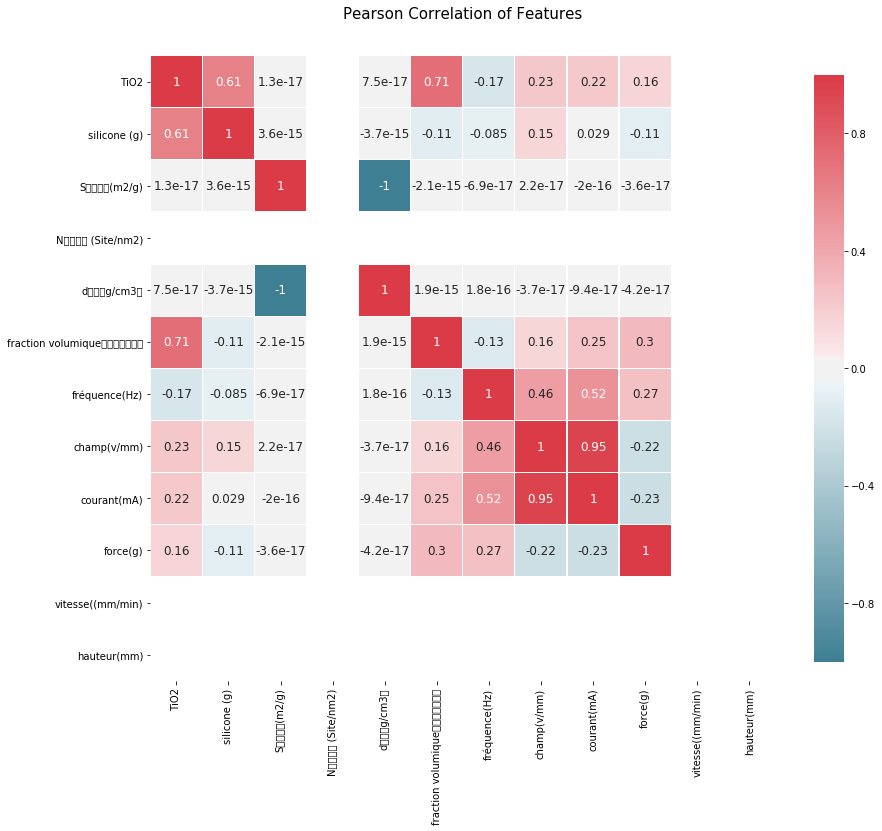

In [5]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data_df.copy().drop(["contrainte(kPa)", "nouveau système"], axis=1))

## Feature exploration

                                 Plots for fraction volumique（体积百分比）                                  


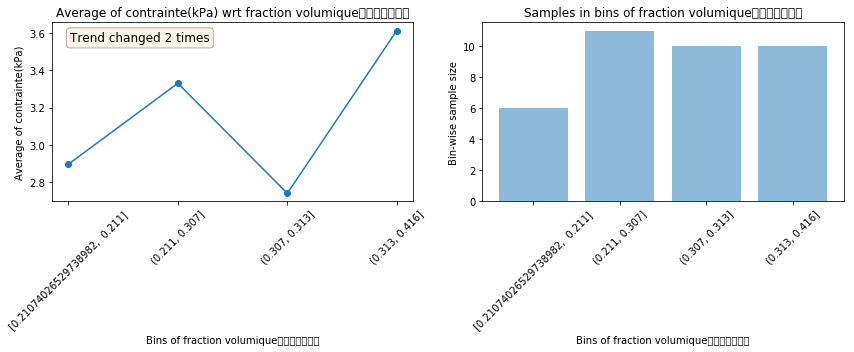

--------------------------------------------------------------------------------------------------------------


                                       Plots for fréquence(Hz)                                        


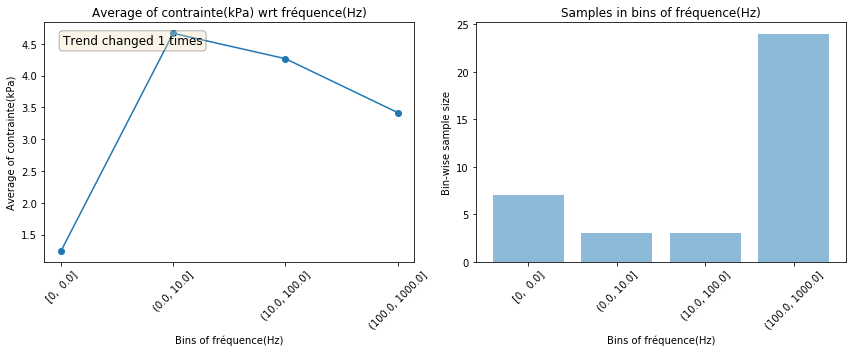

--------------------------------------------------------------------------------------------------------------


                                        Plots for champ(v/mm)                                         


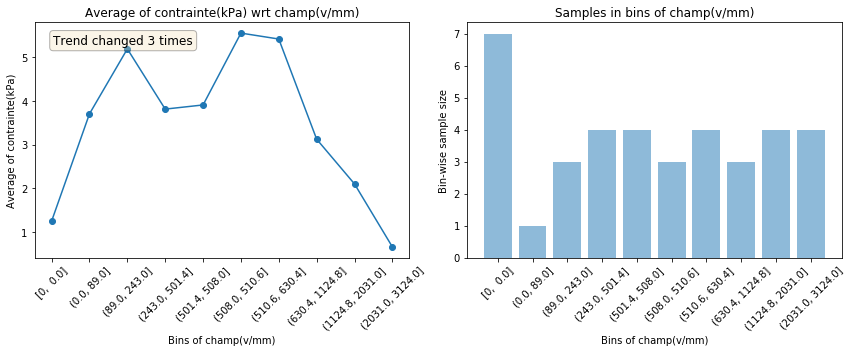

--------------------------------------------------------------------------------------------------------------


                                        Plots for courant(mA)                                         


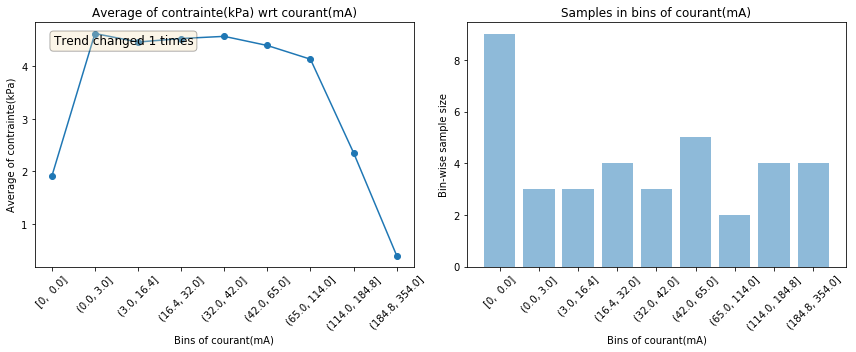

--------------------------------------------------------------------------------------------------------------


                                          Plots for force(g)                                          


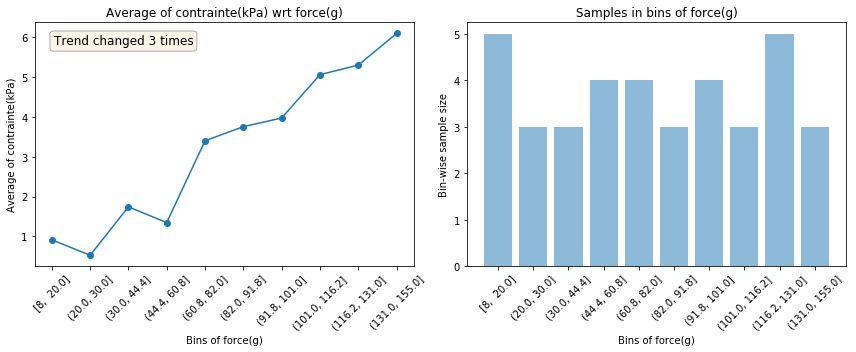

--------------------------------------------------------------------------------------------------------------


                                      Plots for vitesse((mm/min)                                      


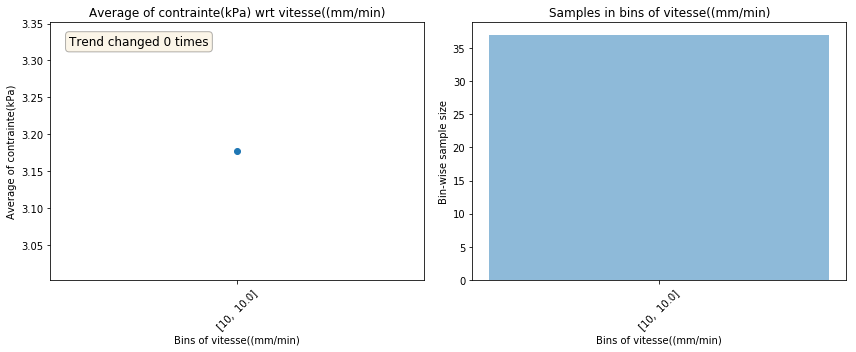

--------------------------------------------------------------------------------------------------------------


                                        Plots for hauteur(mm)                                         


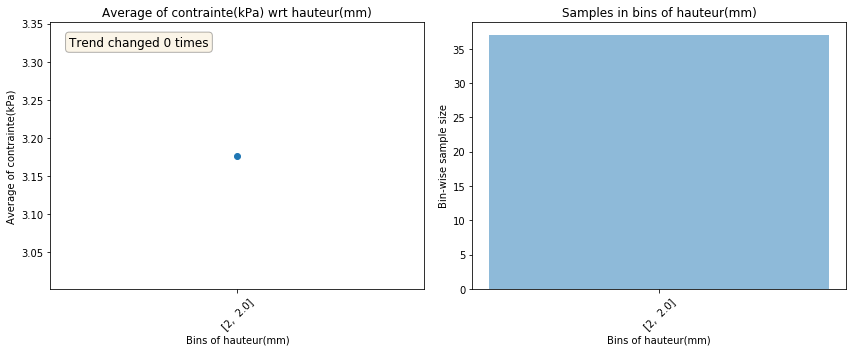

--------------------------------------------------------------------------------------------------------------




In [6]:
try:
    nums = ['fraction volumique（体积百分比）', 'fréquence(Hz)',
            'champ(v/mm)', 'courant(mA)', 'force(g)', 'vitesse((mm/min)', 'hauteur(mm)', ]
    for feature in nums:
        featexp.get_univariate_plots(data=data_df.loc[data_df[feature].notnull()], target_col='contrainte(kPa)',
                              features_list=[feature], bins=10)

except NameError as e:
    print("Check intallation of featexp")
    print(str(e))

## Feature importance

In [7]:
from sklearn.feature_selection import RFE

features = ['TiO2', 'S比表面积(m2/g)', 'N掺杂数量 (Site/nm2)', 'd密度（g/cm3）', 'fraction volumique（体积百分比）', 'fréquence(Hz)',
            'champ(v/mm)', 'courant(mA)', 'force(g)', 'vitesse((mm/min)', 'hauteur(mm)', ]
clf = RandomForestRegressor()
rfe = RFE(estimator=clf, n_features_to_select=1, step=1)
fit = rfe.fit(data_df[features], data_df['contrainte(kPa)'])
print("Feature Ranking: {}".format([features[i-1] for i in fit.ranking_]))

Feature Ranking: ['fréquence(Hz)', 'hauteur(mm)', 'vitesse((mm/min)', 'force(g)', 'd密度（g/cm3）', 'fraction volumique（体积百分比）', 'N掺杂数量 (Site/nm2)', 'S比表面积(m2/g)', 'TiO2', 'courant(mA)', 'champ(v/mm)']


## Parameter tuning under ensemble method with mean square error (smaller the better)

In [9]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .2, train_size = .6, random_state = 0 )

#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostRegressor()),
    ('bc', ensemble.BaggingRegressor()),
    ('etc',ensemble.ExtraTreesRegressor()),
    ('gbc', ensemble.GradientBoostingRegressor()),
    ('rfc', ensemble.RandomForestRegressor()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessRegressor()),
    
#     #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
#     ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
#     ('bnb', naive_bayes.BernoulliNB()),
#     ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsRegressor()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVR()),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBRegressor())

]


#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = range(10, 300, 50)
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .75, .1, .15, .25]
grid_max_depth = [2, 3, 4, 5, 6, 7, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['mse', 'mae']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
                }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
#             'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
#             [{
#             #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
#             'fit_intercept': grid_bool, #default: True
#             #'penalty': ['l1','l2'],
#             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
#             'random_state': grid_seed
#              }],
            
    
#             [{
#             #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
#             'alpha': grid_ratio, #default: 1.0
#              }],
    
    
#             #GaussianNB - 
#             [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [6,7,8,9,10,11,12,14,16,18,20,22], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': list(range(1,50,5))
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
#             'decision_function_shape': ['ovo', 'ovr'], #default:ovr
#             'probability': [True],
#             'random_state': grid_seed
             }],
    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = metrics.make_scorer(metrics.mean_squared_error), n_jobs=-1, return_train_score=True)
    best_search.fit(data_df[features], data_df["contrainte(kPa)"])
    run = time.perf_counter() - start
    
    results = best_search.cv_results_
    best_param = best_search.best_params_
    best_index = results['params'].index(best_param)
    print('The best train mean score {} test {} parameter for {} is {} with a runtime of {:.2f} seconds.'.format(results['mean_train_score'][best_index],results['mean_test_score'][best_index] , clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('-'*10)
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))


print('-'*10)

The best train mean score 0.04502522476627423 test 0.5616893377311772 parameter for AdaBoostRegressor is {'learning_rate': 0.1, 'n_estimators': 10, 'random_state': 0} with a runtime of 40.77 seconds.
The best train mean score 2.6527080021297222 test 3.425264543799954 parameter for BaggingRegressor is {'max_samples': 0.1, 'n_estimators': 10, 'random_state': 0} with a runtime of 19.77 seconds.
The best train mean score 0.38731547589321547 test 0.8127914164270834 parameter for ExtraTreesRegressor is {'criterion': 'mae', 'max_depth': 2, 'n_estimators': 10, 'random_state': 0} with a runtime of 51.37 seconds.
The best train mean score 9.877372652137338e-08 test 0.5416529893227008 parameter for GradientBoostingRegressor is {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300, 'random_state': 0} with a runtime of 1.48 seconds.
The best train mean score 0.18356240540261642 test 0.51147043240576 parameter for RandomForestRegressor is {'criterion': 'mae', 'max_depth': 2, 'n_estimators': 10